Scripts

In [6]:
from newsapi import NewsApiClient
import datetime
import time
import pandas as pd
import os
from newspaper import Article
import sys

In [ ]:
# Initialize NewsAPI Client
api_key = ""  # Replace with API key
newsapi = NewsApiClient(api_key=api_key)

# Input and output file paths
input_file = "news_articles_election_candidates_expanded.csv"
full_content_file = "news_articles_election_candidates_full_content.csv"

# Function to fetch full article content using newspaper3k
def fetch_full_content(article_url):
    try:
        article = Article(article_url)
        article.download()
        article.parse()
        return article.text  # Return the full article text
    except Exception as e:
        return None  # Return None if there is an error

# Set new date range
start_date = datetime.date(2024, 10, 12)  # Continue from where the previous script left off
end_date = datetime.date(2024, 8, 1)  # Adjust end date as needed for backward collection

# Prepare to store results
articles_data = []

# Expanded search queries
queries = [
    "2024 Presidential election",
    "US election AND (Donald Trump OR Kamala Harris)",
    "Biden administration AND 2024 election",
    "(Donald Trump OR Trump) AND 2024 election",
    "(Kamala Harris OR Harris) AND 2024 election",
    "Campaign financing AND 2024 election",
    "Voter turnout AND 2024 election",
    "Presidential debate AND 2024 election",
    "(Donald Trump OR Trump) AND rally AND 2024",
    "(Kamala Harris OR Harris) AND speech AND 2024",
    "(Donald Trump OR Kamala Harris) AND 2024 election",
    "(Trump OR Harris) AND campaign AND 2024 election"
]

# Track API request count to avoid exceeding limits
request_count = 0
max_requests = 100  # Free-tier daily API limit

# Load existing expanded and full content CSV files
existing_expanded_data = pd.read_csv(input_file) if os.path.exists(input_file) else pd.DataFrame()
existing_full_content_data = pd.read_csv(full_content_file) if os.path.exists(full_content_file) else pd.DataFrame()

# Track URLs to avoid duplicates
existing_urls = set(existing_expanded_data["url"]) if not existing_expanded_data.empty else set()
processed_urls = set(existing_full_content_data["url"]) if not existing_full_content_data.empty else set()

# Fetch new articles from NewsAPI
current_date = start_date
while current_date >= end_date:
    # Convert date to string for API
    date_str = current_date.strftime('%Y-%m-%d')
    print(f"Fetching articles for {date_str}...")

    for query in queries:
        try:
            # Check if API limit is reached
            if request_count >= max_requests:
                print("Reached API limit for the day. Exiting script.")
                sys.exit()

            # Fetch articles for the current query and date
            response = newsapi.get_everything(
                q=query,
                from_param=date_str,
                to=date_str,
                language="en",
                sort_by="relevancy",  # Fetch relevant articles
                page_size=100  # Max articles per API call
            )

            # Increment request count
            request_count += 1

            if response.get('status') != 'ok':
                print(f"API error: {response.get('message')}")
                sys.exit()

            # Process the articles
            if response.get('articles'):
                for article in response['articles']:
                    # Only add new articles that are not already saved
                    if article['url'] not in existing_urls:
                        articles_data.append({
                            "query": query,  # Include the query used for tracking
                            "source": article['source']['name'],
                            "author": article['author'],
                            "title": article['title'],
                            "description": article['description'],
                            "url": article['url'],
                            "published_at": article['publishedAt'],
                            "content": article['content']
                        })
                        # Add the URL to the set of existing URLs
                        existing_urls.add(article['url'])
        except Exception as e:
            # Log the error to a file
            with open("error_log.txt", "a") as log_file:
                log_file.write(f"Error fetching articles for {query} on {date_str}: {e}\n")
            print(f"Error fetching articles for {query} on {date_str}: {e}")
    
    # Move to the previous day
    current_date -= datetime.timedelta(days=1)

    # Avoid hitting API limits by adding a small delay between requests
    time.sleep(1)

# Save new articles to the expanded CSV file
if articles_data:
    new_data_df = pd.DataFrame(articles_data)
    new_data_df.to_csv(input_file, mode='a', header=not os.path.exists(input_file), index=False)
    print(f"Appended {len(new_data_df)} new articles to '{input_file}'.")

# Extract full content for new articles only
new_urls = {article["url"] for article in articles_data}  # URLs of newly fetched articles
urls_to_process = new_urls - processed_urls  # Exclude already processed URLs

if urls_to_process:
    full_content_data = []
    for url in urls_to_process:
        print(f"Fetching full content for {url}...")
        full_content = fetch_full_content(url)
        if full_content:
            full_content_data.append({
                "url": url,
                "full_content": full_content
            })
        else:
            print(f"Failed to fetch full content for {url}")

    # Append full content to the full content CSV file
    if full_content_data:
        full_content_df = pd.DataFrame(full_content_data)
        full_content_df.to_csv(full_content_file, mode='a', header=not os.path.exists(full_content_file), index=False)
        print(f"Appended {len(full_content_df)} new full content articles to '{full_content_file}'.")
else:
    print("No new articles to process for full content.")



In [ ]:
# Load the CSV file
file_path = 'news_articles_election_candidates_expanded.csv'
data = pd.read_csv(file_path)

data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9610 entries, 0 to 9609
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   query         9610 non-null   object
 1   source        9610 non-null   object
 2   author        9093 non-null   object
 3   title         9607 non-null   object
 4   description   9598 non-null   object
 5   url           9610 non-null   object
 6   published_at  9610 non-null   object
 7   content       9610 non-null   object
dtypes: object(8)
memory usage: 600.8+ KB


In [9]:
file_path = 'news_articles_election_candidates_full_content.csv'  # Replace with your file path
data_full_content = pd.read_csv(file_path)

data_full_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9610 entries, 0 to 9609
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   query         9610 non-null   object
 1   source        9610 non-null   object
 2   author        9093 non-null   object
 3   title         9607 non-null   object
 4   description   9598 non-null   object
 5   url           9610 non-null   object
 6   published_at  9610 non-null   object
 7   content       9610 non-null   object
 8   full_content  7556 non-null   object
dtypes: object(9)
memory usage: 675.8+ KB


In [10]:
file_size = os.path.getsize('news_articles_election_candidates_full_content.csv') / (1024 * 1024)
print(f"File size: {file_size:.2f} MB")


File size: 47.67 MB


Remove entries with missing full content

In [12]:
# Remove rows with missing full content
data_full_content = data_full_content.dropna(subset=['full_content'])

# Check the updated DataFrame info
data_full_content.info()


<class 'pandas.core.frame.DataFrame'>
Index: 7556 entries, 0 to 9609
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   query         7556 non-null   object
 1   source        7556 non-null   object
 2   author        7084 non-null   object
 3   title         7553 non-null   object
 4   description   7548 non-null   object
 5   url           7556 non-null   object
 6   published_at  7556 non-null   object
 7   content       7556 non-null   object
 8   full_content  7556 non-null   object
dtypes: object(9)
memory usage: 590.3+ KB


In [13]:
# Save the cleaned dataframe to a new CSV file
data_full_content.to_csv('news_articles_election_candidates_full_content_cleaned.csv', index=False)


In [14]:
print("Number of rows (articles):", data_full_content.shape[0])
print("Number of variables (columns):", data_full_content.shape[1])


Number of rows (articles): 7556
Number of variables (columns): 9


In [15]:
# Calculate the number of unique media outlets
unique_media_outlets = data_full_content['source'].nunique()

# Display the number of unique media outlets
print(f"Number of unique media outlets: {unique_media_outlets}")


Number of unique media outlets: 454


In [11]:
data.dropna(subset=['title', 'description'], inplace=True)


In [14]:
data['published_at'] = pd.to_datetime(data['published_at'], errors='coerce')


In [18]:
import re
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply the function to 'content' and 'full_content'
data['content_clean'] = data['content'].apply(clean_text)
data['full_content_clean'] = data['full_content'].apply(clean_text)


In [19]:
data.reset_index(drop=True, inplace=True)


In [21]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9556 entries, 0 to 9555
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   query               9556 non-null   object             
 1   source              9556 non-null   object             
 2   author              9556 non-null   object             
 3   title               9556 non-null   object             
 4   description         9556 non-null   object             
 5   url                 9556 non-null   object             
 6   published_at        9556 non-null   datetime64[ns, UTC]
 7   content             9556 non-null   object             
 8   full_content        9556 non-null   object             
 9   content_clean       9556 non-null   object             
 10  full_content_clean  9556 non-null   object             
dtypes: datetime64[ns, UTC](1), object(10)
memory usage: 821.3+ KB
None


In [22]:
data.to_csv('cleaned_data_victor.csv', index=False)


In [34]:
import pandas as pd

# Load your cleaned DataFrame (assuming it's named df)
num_nodes = data['source'].nunique()
print(f"Number of nodes (media outlets): {num_nodes}")


Number of nodes (media outlets): 497


In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# Combine all articles for each media outlet
outlet_articles = data.groupby('source')['full_content'].apply(' '.join).reset_index()

# Initialize CountVectorizer to extract keywords
vectorizer = CountVectorizer(stop_words='english', max_features=1000)  # Adjust max_features as needed
X = vectorizer.fit_transform(outlet_articles['full_content'])

# Create a DataFrame of keywords for each outlet
keywords_df = pd.DataFrame(X.toarray(), index=outlet_articles['source'], columns=vectorizer.get_feature_names_out())


In [36]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# Calculate cosine similarity matrix
similarity_matrix = cosine_similarity(keywords_df)

# Create a DataFrame for the similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=keywords_df.index, columns=keywords_df.index)


In [39]:
# Set similarity threshold (e.g., 0.1)
threshold = 0.1

# Initialize list for edges
edges = []

# Iterate over the upper triangle of the similarity matrix to avoid duplicates
for i in range(len(similarity_df)):
    for j in range(i+1, len(similarity_df)):
        if similarity_df.iloc[i, j] >= threshold:
            outlet1 = similarity_df.index[i]
            outlet2 = similarity_df.columns[j]
            edges.append((outlet1, outlet2))

num_edges = len(edges)
print(f"Number of edges: {num_edges}")


Number of edges: 106227


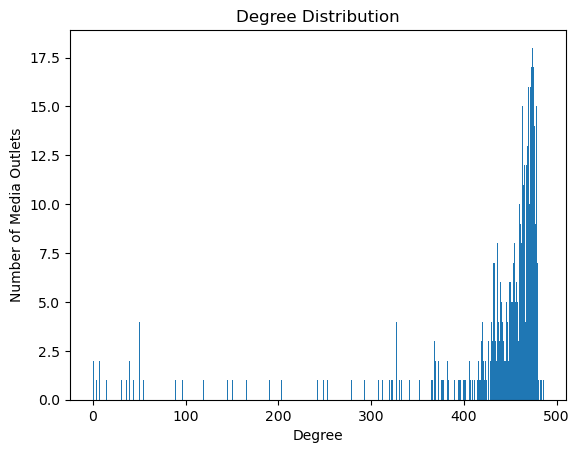

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph
G = nx.Graph()
G.add_nodes_from(keywords_df.index)
G.add_edges_from(edges)

# Calculate degrees
degree_sequence = [d for n, d in G.degree()]

# Plot degree distribution
plt.hist(degree_sequence, bins=range(min(degree_sequence), max(degree_sequence)+1))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Media Outlets")
plt.show()
